In [27]:
!pip install wfdb


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm import tqdm
import os

In [29]:
print("Downloading MIT-BIH Arrhythmia Database...")
download_path = 'data/mit-bih-arrhythmia-database-1.0.0' 
wfdb.dl_database('mitdb', dl_dir=download_path)
print(f"Download complete! Files saved to: {download_path}")

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [30]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=40, fs=360, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [31]:
def label_group(label):
    """Group beat types into main categories"""
    if label in ['N', 'L', 'R', 'e', 'j']:
        return 'N'  # Normal
    elif label in ['A', 'a', 'J', 'S']:
        return 'S'  # Supraventricular
    elif label in ['V', 'E']:
        return 'V'  # Ventricular
    elif label in ['F']:
        return 'F'  # Fusion
    else:
        return 'Q'  # Other/Unknown

In [32]:
# Segmentation parameters
window_size = 250  # total length
pre, post = 100, 150  # samples before and after R-peak

all_X = []
all_y = []

# Get list of record files
record_files = [f.split('.')[0] for f in os.listdir(download_path) if f.endswith('.dat')]
print(f"\nFound {len(record_files)} records to process")

# Process each record
for rec_name in tqdm(sorted(record_files), desc="Processing records"):
    try:
        # Read record and annotations
        record = wfdb.rdrecord(os.path.join(download_path, rec_name))
        annotation = wfdb.rdann(os.path.join(download_path, rec_name), 'atr')

        # Get signal from first channel and apply filtering
        signal = record.p_signal[:, 0]
        filtered_signal = bandpass_filter(signal, fs=record.fs)

        ann_samples = annotation.sample
        ann_symbols = annotation.symbol

        # Extract segments around R-peaks
        segments = []
        labels = []

        for i, r_peak in enumerate(ann_samples):
            # Skip if segment would be incomplete
            if r_peak - pre < 0 or r_peak + post >= len(filtered_signal):
                continue

            beat_segment = filtered_signal[r_peak - pre:r_peak + post]
            segments.append(beat_segment)
            labels.append(label_group(ann_symbols[i]))

        if len(segments) > 0:
            segments = np.array(segments)
            labels = np.array(labels)

            # Normalize each segment (z-score normalization)
            X = (segments - np.mean(segments, axis=1, keepdims=True)) / \
                (np.std(segments, axis=1, keepdims=True) + 1e-6)

            all_X.append(X)
            all_y.append(labels)

    except Exception as e:
        print(f"\nError processing {rec_name}: {str(e)}")
        continue


Found 48 records to process


Processing records: 100%|██████████| 48/48 [00:06<00:00,  7.28it/s]


In [33]:
print("\nCombining data from all records...")
X_all = np.vstack(all_X)
y_all = np.hstack(all_y)

# Add channel dimension for CNN input
X_all = X_all[..., np.newaxis]

# Encode labels
le = LabelEncoder()
int_labels = le.fit_transform(y_all)

onehot = OneHotEncoder(sparse_output=False)
y_encoded = onehot.fit_transform(int_labels.reshape(-1, 1))

print(f"\nFinal dataset shape:")
print(f"X: {X_all.shape}")
print(f"y: {y_encoded.shape}")
print(f"\nLabel distribution:")
unique, counts = np.unique(y_all, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label}: {count} samples ({count/len(y_all)*100:.2f}%)")



Combining data from all records...

Final dataset shape:
X: (112559, 250, 1)
y: (112559, 5)

Label distribution:
  F: 802 samples (0.71%)
  N: 90592 samples (80.48%)
  Q: 11149 samples (9.91%)
  S: 2781 samples (2.47%)
  V: 7235 samples (6.43%)


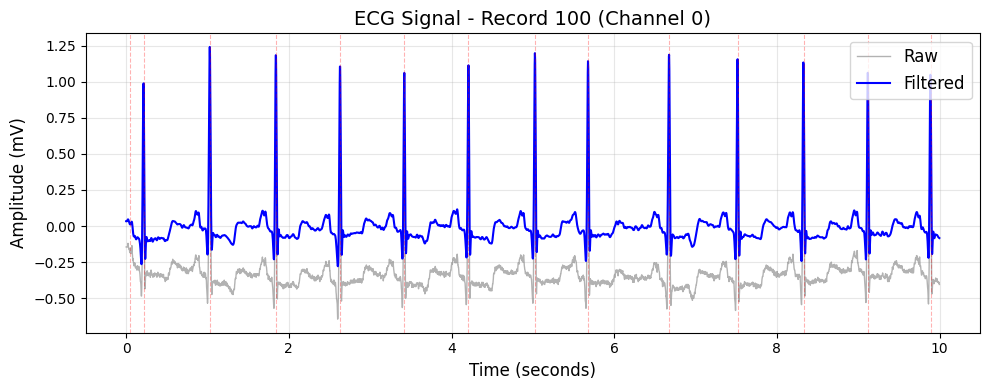

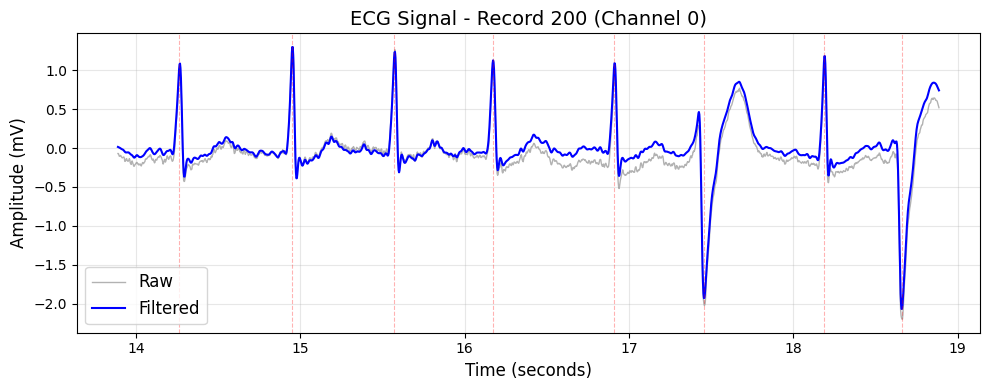

In [34]:
def visualize_signal(record_name, start=0, length=3000, channel=0):
    """
    Visualize raw and filtered ECG signal for any record

    Args:
        record_name: Name of the record (e.g., '100', '101')
        start: Starting sample index
        length: Number of samples to plot
        channel: Channel index (0 or 1 for MIT-BIH)
    """
    # Load record
    record = wfdb.rdrecord(os.path.join(download_path, str(record_name)))
    annotation = wfdb.rdann(os.path.join(download_path, str(record_name)), 'atr')

    # Extract signal
    signal_raw = record.p_signal[:, channel]
    signal_filtered = bandpass_filter(signal_raw, fs=record.fs)

    # Get R-peaks in the displayed range
    r_peaks = annotation.sample
    r_peaks_in_range = r_peaks[(r_peaks >= start) & (r_peaks < start + length)]

    # Plot
    plt.figure(figsize=(10, 4))
    time_axis = np.arange(start, start + length) / record.fs

    plt.plot(time_axis, signal_raw[start:start+length],
             label='Raw', alpha=0.6, linewidth=1, color='gray')
    plt.plot(time_axis, signal_filtered[start:start+length],
             label='Filtered', linewidth=1.5, color='blue')

    # Mark R-peaks
    for r_peak in r_peaks_in_range:
        plt.axvline(r_peak/record.fs, color='red', alpha=0.3, linestyle='--', linewidth=0.8)

    plt.legend(fontsize=12)
    plt.title(f'ECG Signal - Record {record_name} (Channel {channel})', fontsize=14)
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Amplitude (mV)', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Usage examples:
visualize_signal('100', start=0, length=3600)  # First 10 seconds
visualize_signal('200', start=5000, length=1800)  # Different record

Sample beats visualization saved to: sample_beats.png


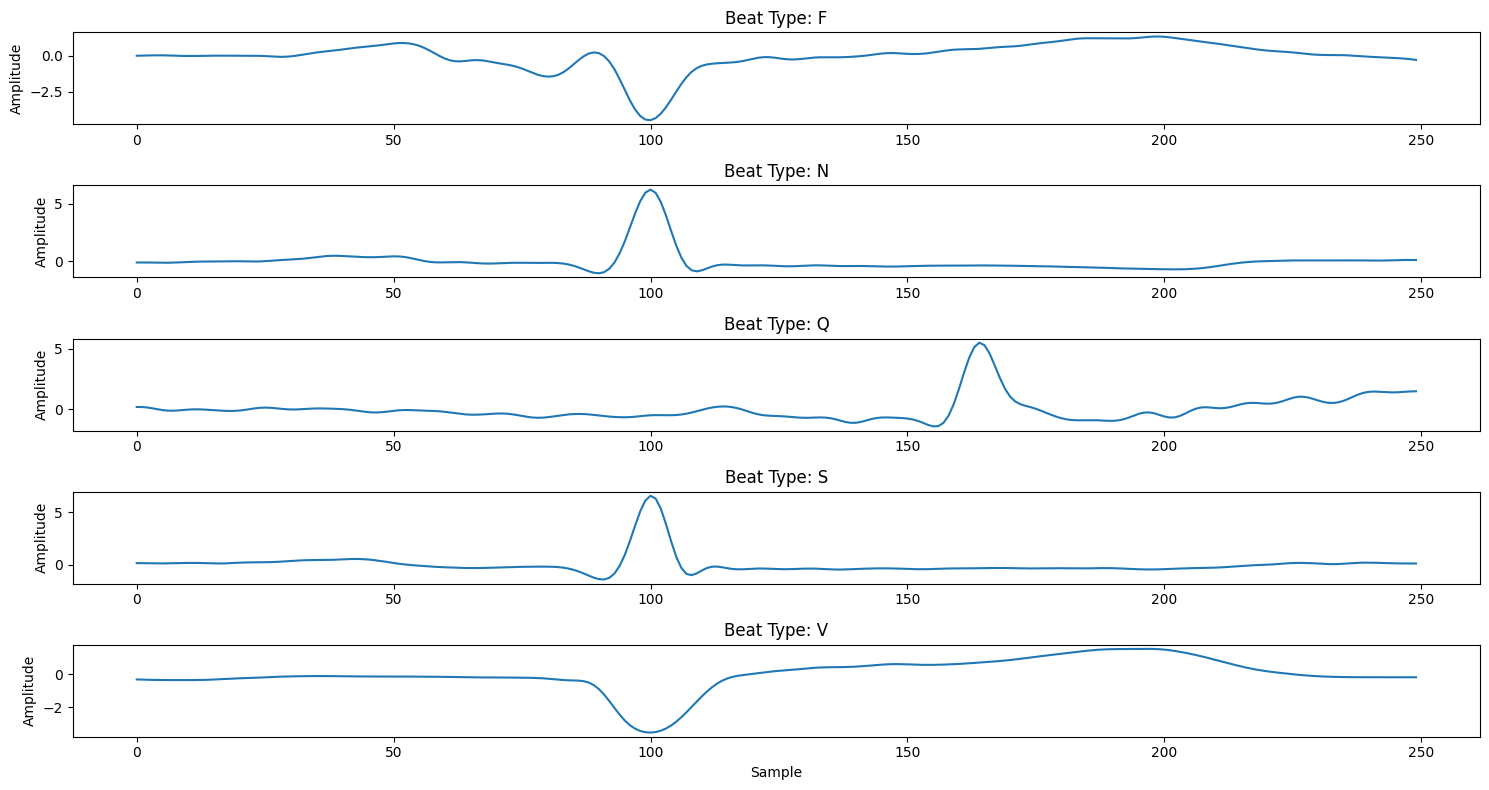

In [35]:
plt.figure(figsize=(15, 8))
for i, label in enumerate(le.classes_):
    idx = np.where(y_all == label)[0][0]  # Get first occurrence
    plt.subplot(len(le.classes_), 1, i+1)
    plt.plot(X_all[idx, :, 0])
    plt.title(f'Beat Type: {label}')
    plt.ylabel('Amplitude')
    if i == len(le.classes_) - 1:
        plt.xlabel('Sample')
plt.tight_layout()
plt.savefig('sample_beats.png', dpi=150, bbox_inches='tight')
print("Sample beats visualization saved to: sample_beats.png")
plt.show()

In [10]:
output_file = 'data/ecg_mitdb_processed.npz'
np.savez(output_file, X=X_all, y=y_encoded, label_names=le.classes_)
print(f"\nDataset saved to: {output_file}")


Dataset saved to: data/ecg_mitdb_processed.npz


In [3]:
import numpy as np

# Load the .npz file
data = np.load('data/ecg_mitdb_processed.npz')

# Extract stored arrays
X = data['X']
y = data['y']
label_names = data['label_names']

print("X Shape:", X.shape)
print("y Shape:", y.shape)
print("Label Names:", label_names)


X Shape: (112559, 250, 1)
y Shape: (112559, 5)
Label Names: ['F' 'N' 'Q' 'S' 'V']


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import classification_report, accuracy_score


In [5]:

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)        # (N, 250, 1)
y = torch.tensor(np.argmax(y, axis=1), dtype=torch.long)  # convert from one-hot → class index


In [6]:
dataset = TensorDataset(X, y)

train_len = int(0.8 * len(dataset))
val_len = int(0.1 * len(dataset))
test_len = len(dataset) - train_len - val_len

train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


Train: 90047, Val: 11255, Test: 11257


In [7]:
class CNN2D_LSTM(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN2D_LSTM, self).__init__()

        # 2D CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(7, 1), padding=(3, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),    # Output height: 125

            nn.Conv2d(32, 64, kernel_size=(5, 1), padding=(2, 0)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),    # Output height: 62
        )

        # LSTM expects (batch, time, features)
        # After CNN: (batch, 64, 62, 1) → we reshape to (batch, 62, 64)
        self.lstm = nn.LSTM(input_size=64, hidden_size=64,
                            num_layers=2, batch_first=True,
                            bidirectional=True)

        # Classification Head
        self.fc = nn.Sequential(
            nn.Linear(64 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: (batch, 250, 1)
        x = x.unsqueeze(1)              # → (batch, 1, 250, 1)

        x = self.cnn(x)                 # → (batch, 64, 62, 1)
        x = x.squeeze(-1)               # → (batch, 64, 62)
        x = x.permute(0, 2, 1)          # → (batch, 62, 64)

        _, (h, _) = self.lstm(x)        # h: (4, batch, 64) for Bi-LSTM
        h = torch.cat((h[-2], h[-1]), dim=1)

        return self.fc(h)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN2D_LSTM(num_classes=len(label_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
print(model)

CNN2D_LSTM(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=5, bias=True)
  )
)


In [10]:
def train_model(model, epochs=30):
    train_loss_values = []
    val_loss_values = []
    train_acc_values = []
    val_acc_values = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, pred = torch.max(outputs, 1)
            correct_train += (pred == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_acc = correct_train / total_train
        train_loss_values.append(total_loss)
        train_acc_values.append(train_acc)

        # Validation accuracy & loss
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                _, pred = torch.max(outputs, 1)
                correct_val += (pred == y_batch).sum().item()
                total_val += y_batch.size(0)

        val_acc = correct_val / total_val
        val_loss_values.append(val_loss)
        val_acc_values.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return train_loss_values, val_loss_values, train_acc_values, val_acc_values

train_loss, val_loss, train_acc, val_acc = train_model(model, epochs=50)


Epoch 1/50 | Train Loss: 259.7904 | Val Loss: 15.6298 | Train Acc: 0.8971 | Val Acc: 0.9515
Epoch 2/50 | Train Loss: 98.3663 | Val Loss: 12.0804 | Train Acc: 0.9630 | Val Acc: 0.9607
Epoch 3/50 | Train Loss: 68.8935 | Val Loss: 8.1242 | Train Acc: 0.9733 | Val Acc: 0.9739
Epoch 4/50 | Train Loss: 57.9941 | Val Loss: 7.0371 | Train Acc: 0.9777 | Val Acc: 0.9787
Epoch 5/50 | Train Loss: 50.6068 | Val Loss: 6.4832 | Train Acc: 0.9798 | Val Acc: 0.9796
Epoch 6/50 | Train Loss: 45.4022 | Val Loss: 6.5135 | Train Acc: 0.9822 | Val Acc: 0.9800
Epoch 7/50 | Train Loss: 41.0122 | Val Loss: 5.6799 | Train Acc: 0.9836 | Val Acc: 0.9822
Epoch 8/50 | Train Loss: 38.4129 | Val Loss: 5.6400 | Train Acc: 0.9843 | Val Acc: 0.9816
Epoch 9/50 | Train Loss: 34.4053 | Val Loss: 5.3054 | Train Acc: 0.9861 | Val Acc: 0.9844
Epoch 10/50 | Train Loss: 32.4605 | Val Loss: 5.8495 | Train Acc: 0.9861 | Val Acc: 0.9813
Epoch 11/50 | Train Loss: 30.9170 | Val Loss: 5.2189 | Train Acc: 0.9873 | Val Acc: 0.9838
Epoch

In [15]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
test_loss = 0
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

test_loss = test_loss / len(test_loader)
print(f"\nTest Loss: {test_loss:.4f}")

y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ------------------------------
# Accuracy
# ------------------------------
acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {acc:.4f}")

# ------------------------------
# Precision, Recall, F1 (Weighted)
# ------------------------------
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted'
)

print(f"\nPrecision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")

# ------------------------------
# Classification Report (Per-Class)
# ------------------------------
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

# ------------------------------
# Compute Test Loss
# ------------------------------




Test Loss: 0.0584

Test Accuracy: 0.9891

Precision (Weighted): 0.9890
Recall (Weighted):    0.9891
F1-score (Weighted):  0.9890

Classification Report:

              precision    recall  f1-score   support

           F     0.8293    0.8000    0.8144        85
           N     0.9931    0.9958    0.9944      9054
           Q     0.9831    0.9831    0.9831      1122
           S     0.9549    0.9228    0.9386       298
           V     0.9796    0.9628    0.9711       698

    accuracy                         0.9891     11257
   macro avg     0.9480    0.9329    0.9403     11257
weighted avg     0.9890    0.9891    0.9890     11257



Confusion matrices saved to: confusion_matrices.png


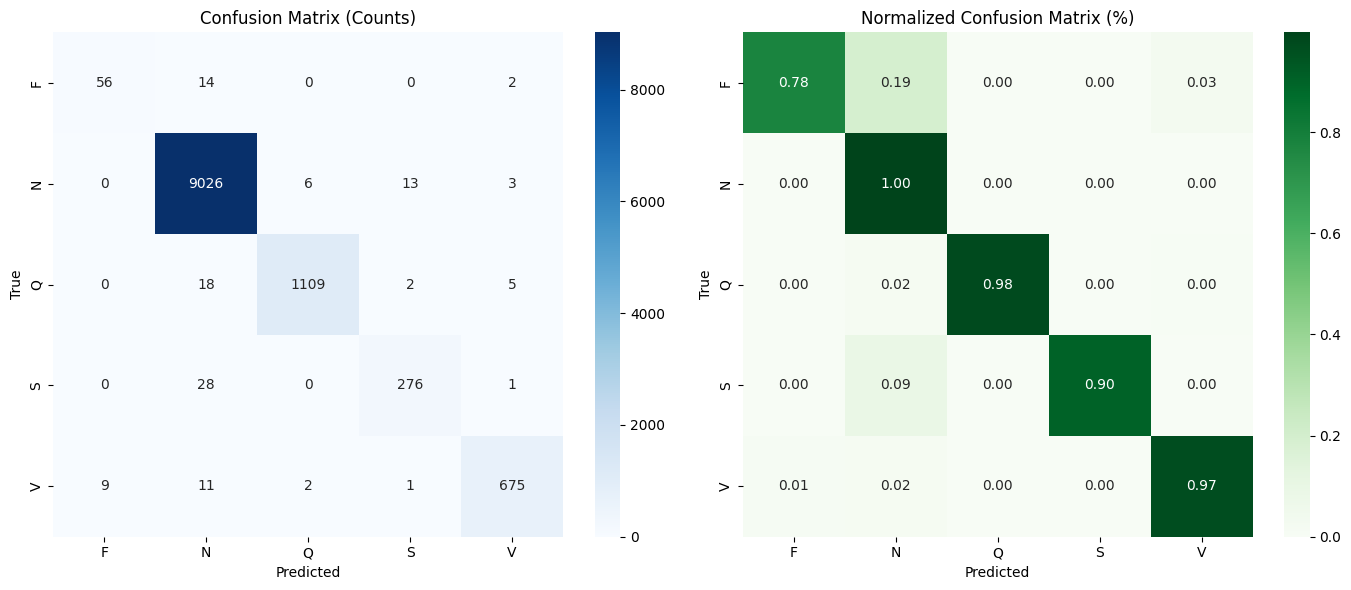


Visualizing sample predictions...
Sample predictions saved to: sample_predictions.png


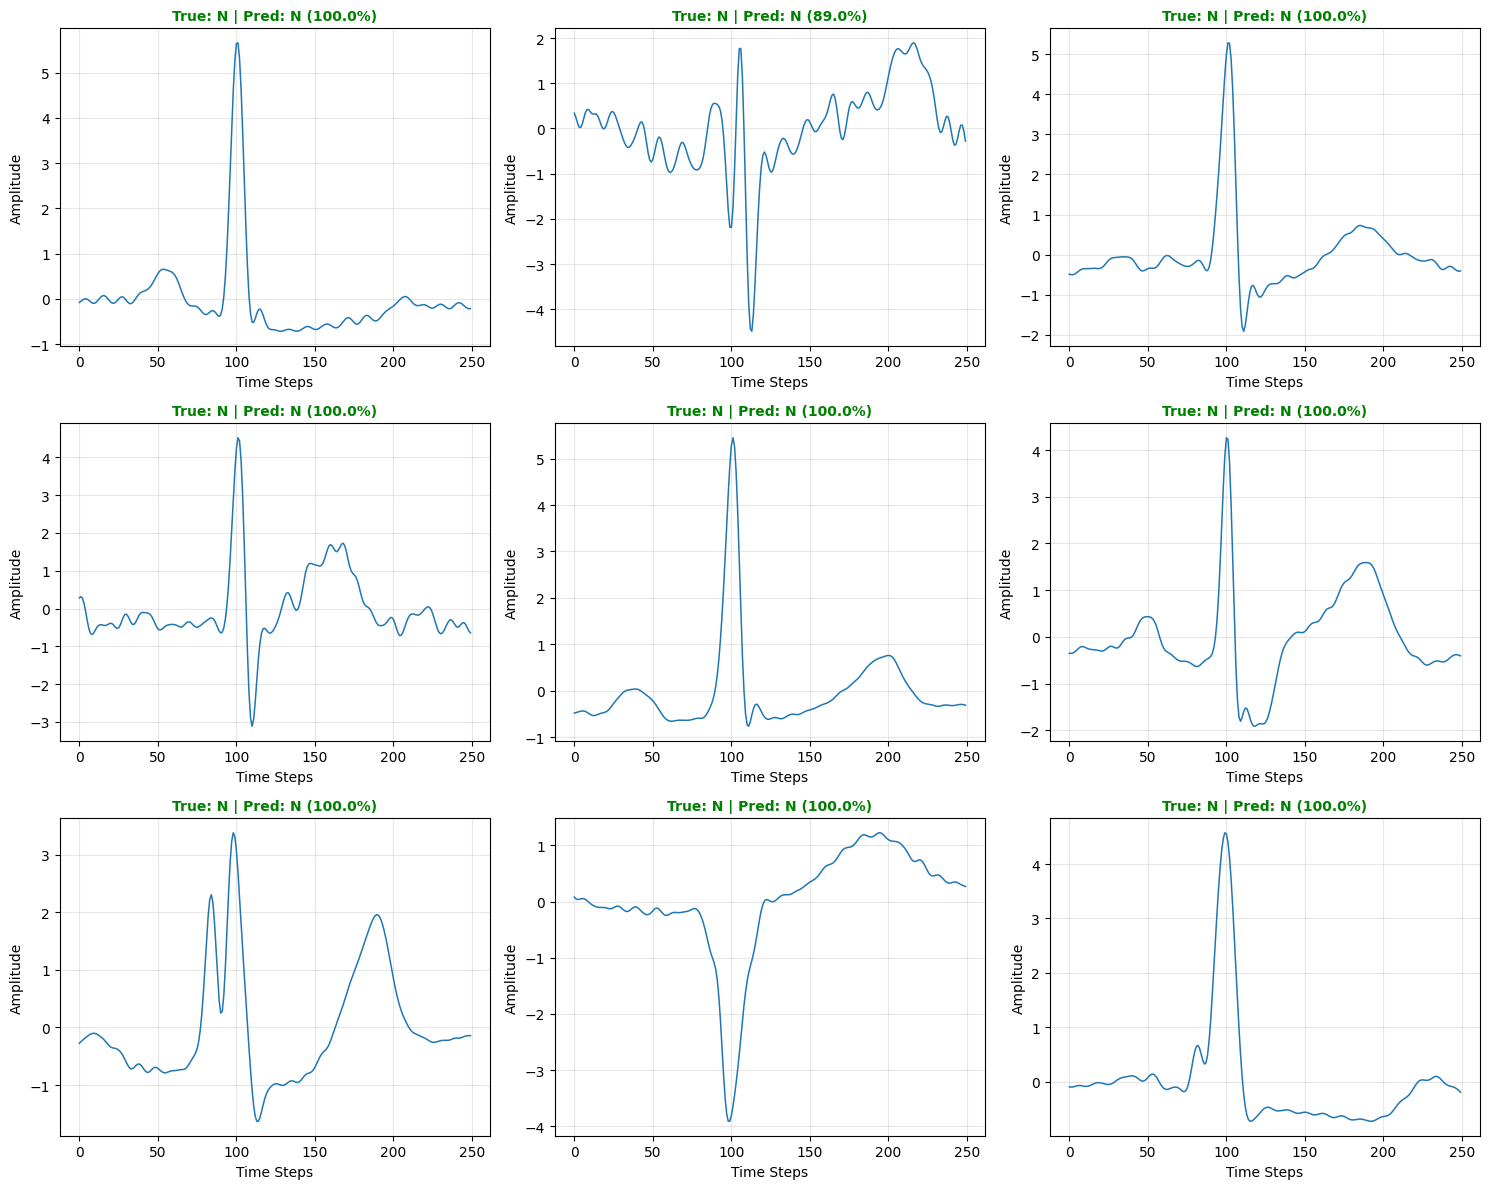

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ---------------------------------------------------------
# CONFUSION MATRIX (RAW + NORMALIZED)
# ---------------------------------------------------------
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Raw Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_xticklabels(label_names)
axes[0].set_yticklabels(label_names)

# Normalized Confusion Matrix
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=axes[1])
axes[1].set_title("Normalized Confusion Matrix (%)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_xticklabels(label_names)
axes[1].set_yticklabels(label_names)

plt.tight_layout()
plt.savefig("confusion_matrices.png", dpi=150, bbox_inches='tight')
print("Confusion matrices saved to: confusion_matrices.png")
plt.show()

# ---------------------------------------------------------
# SAMPLE ECG PREDICTION VISUALIZATION (9 RANDOM SIGNALS)
# ---------------------------------------------------------
print("\nVisualizing sample predictions...")

# ensure test arrays exist (X_test, y_pred_probs, y_true, y_pred)
# Convert entire test set into numpy for visualization
X_test_np = []
y_test_np = []
y_pred_probs = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)

        outputs = model(X_batch)  # raw logits
        probs = torch.softmax(outputs, dim=1)  # convert to probabilities

        X_test_np.append(X_batch.cpu().numpy())
        y_test_np.append(y_batch.numpy())
        y_pred_probs.append(probs.cpu().numpy())

# Concatenate all test batches
X_test_np = np.concatenate(X_test_np, axis=0)         # shape: (test_samples, 250, 1)
y_test_np = np.concatenate(y_test_np, axis=0)         # shape: (test_samples,)
y_pred_probs = np.concatenate(y_pred_probs, axis=0)   # shape: (test_samples, 5)

# Ensure y_true and y_pred are numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

num_samples = min(9, len(X_test_np))
random_indices = np.random.choice(len(X_test_np), num_samples, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    true_label = label_names[y_true[idx]]
    pred_label = label_names[y_pred[idx]]
    confidence = y_pred_probs[idx][y_pred[idx]] * 100

    axes[i].plot(X_test_np[idx, :, 0], linewidth=1.1)

    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f'True: {true_label} | Pred: {pred_label} ({confidence:.1f}%)',
                      color=color, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Time Steps')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("sample_predictions.png", dpi=150, bbox_inches='tight')
print("Sample predictions saved to: sample_predictions.png")
plt.show()

